# Assigment 06 - t-SNE and more

> As usual: The solution is available in branch "musterloesung"!

## Task 1: Python (as usual)

In t-SNE we are using Student t-distrubution instead of Gaussian distribution:


a) Plot both distributions in one diagram for comparison.



First: What is the formular of normal and t-distribution?

normal distrbution:

$$f(x)=\frac{1}{\sigma \sqrt{2 \pi}}\exp^{-(x-\mu)^2/2\sigma^2}$$

where, μ is the population mean, σ is the standard deviation and σ2 is the variance.

t Student distribution:

$$f(x, \nu) = \frac{\Gamma((\nu+1)/2)}
                        {\sqrt{\pi \nu} \Gamma(\nu/2)}
                    (1+x^2/\nu)^{-(\nu+1)/2}$$

where `x` is a real number and the degrees of freedom parameter `\nu` (denoted ``df`` in the implementation) satisfies `\nu > 0`. `\Gamma` is the gamma function.

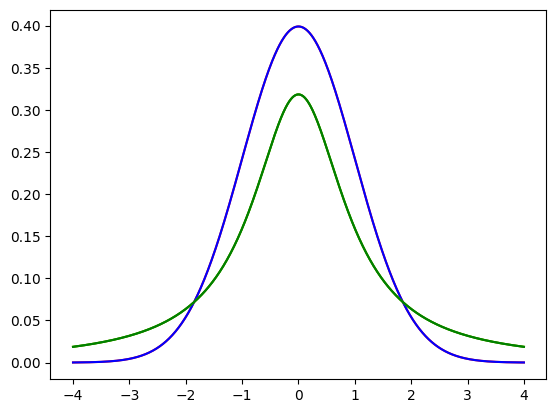

In [7]:
# Library imports
import numpy as np
import scipy.stats as stats
from scipy.special import gamma
import matplotlib.pyplot as plt
%matplotlib inline

def norm(x, mu=0, sigma=1):
    return 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (x - mu)**2 / (2 * sigma**2) )

def t(x, df=1):
    return gamma((df+1)/2)/(gamma(df/2) * (np.sqrt(df*np.pi)))*(1+(x**2)/df)**(-(df+1)/2)

# Defining the x and y variables for the graph
x = np.linspace(-4, 4, 1000)
y1 = stats.norm.pdf(x)
y2 = norm(x)

df = 1
y3 = stats.t.pdf(x, df)
y4 = t(x,df)

df = 10
y5 = stats.t.pdf(x, df)
y6 = t(x,df)

mu, sigma = 0, 0.3
s = np.random.normal(mu, sigma, 1000)

# Plotting
plt.plot(x, y1, color='red')
plt.plot(x, y2, color='blue')
plt.plot(x, y3, color='yellow')

plt.plot(x, y3, color='green')
plt.plot(x, y4, color='green')



b) Try to explain why Student t-distrubution works better for dimension reduction.

- Visually t-distribution looks much like a normal distribution but generally has fatter tails, which means higher variability in the data.
- Using Student distribution has exactly what we need. It “falls” quickly and has a “long tail” so points won’t get squashed into a single point: Crowding problem!

## Task 2: Some work with t-SNE and PCA

a) **Compare t-SNE with PCA: Run on a given data set PCA and t-SNE and compare the results.** Please plot your results like this

In [2]:
import numpy as np
import pandas as pd
from time import time

# Packages to perform dimensionality reduction
import sklearn.datasets
import sklearn.decomposition
import sklearn.manifold

# Packages for plotting
import matplotlib.pyplot as plt
from matplotlib import offsetbox

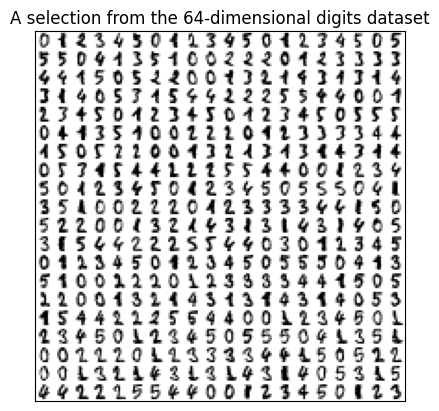

In [3]:
# Load the data from sklearn (number 0 to 5 only)
digits = sklearn.datasets.load_digits(n_class=6)

# Store the data and targets
digit_images = digits.data
digit_classes = digits.target

# The data are rows of pixel values, and each pixel value is a feature (64 pixels in an 8x8 image).
n_samples, n_features = digit_images.shape

# Take a look at the data
n_img_per_row = 20
img = np.zeros((10 * n_img_per_row, 10 * n_img_per_row))
for i in range(n_img_per_row):
    ix = 10*i + 1
    for j in range(n_img_per_row):
        iy = 10*j + 1
        img[ix:ix + 8, iy:iy + 8] = digit_images[i * n_img_per_row + j].reshape((8,8))
        
plt.imshow(img, cmap=plt.cm.binary)
plt.xticks([])
plt.yticks([])
plt.title('A selection from the 64-dimensional digits dataset');

In [4]:
def plot_embedding(embed, title=None, show_classes=True, show_examples=True):
    # Determine range of values of embedded points
    x_min, x_max = np.min(embed, 0), np.max(embed, 0)
    # Scale all points between 0 and 1
    scaled_embed = (embed - x_min) / (x_max - x_min)
    
    # Instantiate figure
    plt.figure()
    ax = plt.subplot(111)
    
    if show_classes:
        # Color each number differently (shows how we expect data to cluster)
        for i in range(scaled_embed.shape[0]):
            plt.plot(scaled_embed[i,0], scaled_embed[i,1], '.',
                     color = plt.cm.Set1(digit_classes[i]/10))
    else:
        plt.plot(scaled_embed[:,0], scaled_embed[:,1], '.k')
    
    if show_examples:
        if hasattr(offsetbox, 'AnnotationBbox'):
            # Only print thumbnail with matplotlib > 1.0;
            # initialize shown_images array
            shown_images = np.array([[1, 1]])

            # Iterate through the number of digits we imported
            for i in range(digits.data.shape[0]):
                dist = np.sum((scaled_embed[i] - shown_images) **2, 1)
                # Don't put thumbnails too close together
                if np.min(dist) < 4e-3:
                    continue
                # Concatenate the  locations of the images to be plotted
                shown_images = np.r_[shown_images, [scaled_embed[i]]]
                # Define the grayscale image of the number
                imagebox = offsetbox.AnnotationBbox(
                    offsetbox.OffsetImage(digits.images[i], cmap=plt.cm.gray_r),
                    scaled_embed[i])
                ax.add_artist(imagebox)
                
    # Remove x and y ticks
    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)

In [5]:
# Time the PCA computation
t0 = time()

# Use singular value decomposition to find eigenvalues and eigenvectors
digit_pca = sklearn.decomposition.PCA(n_components=2)

# Transform the data
embed_pca = digit_pca.fit_transform(digit_images)

# Store the time
t_pca = time() - t0

# Print time 
print('PCA took %.3fs.' % t_pca)


# Time the tSNE computation
t0 = time()

# Find the optimal low-dimensional representation with t-SNE
tsne = sklearn.manifold.TSNE(n_components=2, perplexity=50, init='pca', random_state=500)
embed_tsne = tsne.fit_transform(digit_images)

# Store the time
t_tsne = time() - t0

# Print time
print('t-SNE took %.3fs.' % t_tsne)

PCA took 1.522s.
t-SNE took 3.986s.


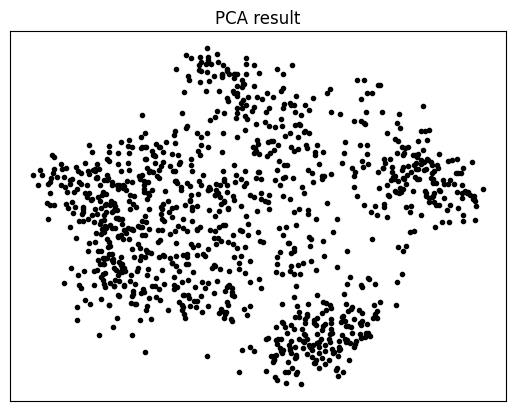

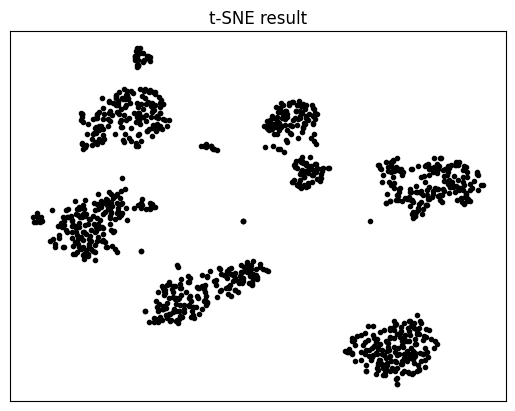

In [6]:
plot_embedding(embed_pca, "PCA result", show_classes=False, show_examples=False)
plot_embedding(embed_tsne, "t-SNE result", show_classes=False, show_examples=False)

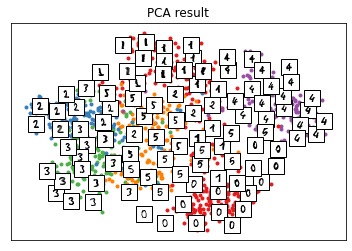

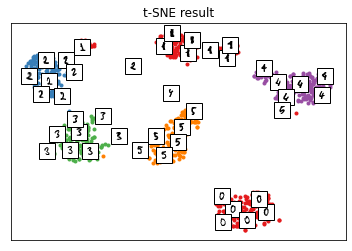

In [15]:
plot_embedding(embed_pca, "PCA result")
plot_embedding(embed_tsne, "t-SNE result")

## Task 3: More  math :-) on Covariance

The covariance matrix is a math concept that occurs in several areas of machine learning. If you have a set of n numeric data items, where each data item has d dimensions, then the covariance matrix is a d-by-d symmetric square matrix where there are variance values on the diagonal and covariance values off the diagonal.

Suppose you have a set of n=5 data items, representing 5 people, where each data item has a height (X), test score (Y), and age (Z) (therefore d = 3):


```
        X      Y     Z
       height score  age
       64.0   580.0  29.0
       66.0   570.0  33.0
       68.0   590.0  37.0
       69.0   660.0  46.0
       73.0   600.0  55.0
```

a) Calculate the mean of each column by hand

meanX =	68.0
meanY = 600.0
meanZ = 40.0


b) Calculate the covariance by hand

```
    X        Y        Z
X   11.50    50.00   34.75
Y   50.00  1250.00  205.00
Z   34.75   205.00  110.00
```

Var(X) = [ (64–68.0)^2 + (66–68.0^2 + (68-68.0)^2 + (69-68.0)^2 +(73-68.0)^2 ] / (5-1) = (16.0 + 4.0 + 0.0 + 1.0 + 25.0) / 4 = 46.0 / 4 = 11.50

Covar(XY) = [ (64-68.0)*(580-600.0) + (66-68.0)*(570-600.0) + (68-68.0)*(590-600.0) + (69-68.0)*(660-600.0) + (73-68.0)*(600-600.0) ] / (5-1) = [80.0 + 60.0 + 0 + 60.0 + 0] / 4 = 200 / 4 = 50.0

...

c) Write a short Python programm and validate your result

In [58]:
import numpy as np

A = np.array([[64.0,  580.0,  29.0],[66.0, 570.0, 33.0],[68.0, 590.0, 37.0],[69.0, 660.0, 46.0],[73.0, 600.0, 55.0]])

X = A[:,0]
Y = A[:,1]
Z = A[:,2]

print(f'value    X     Y      Z')
print(f'mean{np.mean(X): >6} {np.mean(Y): >6} {np.mean(Z): >6}')

print()
print("Covariance Matrix")
print(np.cov(A.T))

value    X     Y      Z
mean  68.0  600.0   40.0

Covariance Matrix
[[  11.5    50.     34.75]
 [  50.   1250.    205.  ]
 [  34.75  205.    110.  ]]
